### Load the libraries

In [1]:
import pandas as pd #Data to panel data
import geopandas as gpd #shape file to panel data
from shapely.geometry import Point #Shape file objects
import numpy as np #fast numerical calculations
import xml.etree.ElementTree as et #xml file traversal
from math import sin, cos, sqrt, atan2, radians #simple math formulas
from urllib.request import urlopen #url accessing
from bs4 import BeautifulSoup #html parser
import re #reular expression usage
from sklearn import linear_model # To linear regresion on dataset

### Load the housing data

In [2]:
data = pd.read_csv("inp_data.csv") # Contains data
data.head() #have a look

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,0.0,49.0,-37.82540,145.04700
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.0,119.0,-37.80160,144.99560
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.0,10.0,-37.68104,144.74608
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.0,69.0,-37.76221,144.94055
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,0.0,6.0,-37.83610,144.99210


Do a little bit of data cleaning.

In [3]:
#remove the duplicate rows based on
data.drop_duplicates(subset ="ID", keep = False, inplace = True) 
  
data = data.reset_index(level=0, drop=True)

In [4]:
#correct the zero bathroom error
for i in range(len(data)):
    if data['Bathroom'][i] == 0.0:
        data['Bathroom'][i] = data['Rooms'][i] - 1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [5]:
#fix the zero landsize error
training_data = data[data['Landsize'] != 0.0][['Rooms', 'Price', 'Bathroom', 'Car']]
training_target = data[data['Landsize'] != 0.0]['Landsize']
test_data = data[data['Landsize'] == 0.0][['Rooms', 'Price', 'Bathroom', 'Car']]
test_target = data[data['Landsize'] == 0.0]['Landsize']

lm = linear_model.LinearRegression()
model = lm.fit(training_data, training_target) #model fitting
predictions = lm.predict(test_data) #prediction

count = 0
for i in test_data.index:
    data['Landsize'][i] = predictions[count]
    count += 1

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


## Get the Suburb of the property

Load the shape file into a dataframe using geopandas.

In [6]:
shape_data = gpd.GeoDataFrame.from_file("VIC_LOCALITY_POLYGON_shp.shp") #shape file data
shape_data.head() #have a look

,LC_PLY_PID,DT_CREATE,DT_RETIRE,LOC_PID,VIC_LOCALI,VIC_LOCA_1,VIC_LOCA_2,VIC_LOCA_3,VIC_LOCA_4,VIC_LOCA_5,VIC_LOCA_6,VIC_LOCA_7,geometry
0,6670,2011-08-31,None,VIC2615,2012-04-27,None,UNDERBOOL,None,None,G,None,2,"POLYGON ((141.74552399 -35.07228701, 141.74552..."
1,6671,2011-08-31,None,VIC1986,2012-04-27,None,NURRAN,None,None,G,None,2,"POLYGON ((148.668767 -37.39571245, 148.6687620..."
2,6672,2011-08-31,None,VIC2862,2012-04-27,None,WOORNDOO,None,None,G,None,2,"POLYGON ((142.92287999 -37.97885997, 142.90449..."
3,6673,2011-08-31,None,VIC734,2017-08-09,None,DEPTFORD,None,None,G,None,2,"POLYGON ((147.82335712 -37.66000897, 147.82312..."
4,6674,2011-08-31,None,VIC2900,2012-04-27,None,YANAC,None,None,G,None,2,"POLYGON ((141.279783 -35.99858911, 141.2798853..."


* Convert the latitude and longitude into a single point object.
* Use the point object to see whether it lies in a polygon in the shapefile.
* If it does get the name of the suburb.

In [7]:
#convert lat and long to point object
data['Point'] = data[['Longtitude', 'Lattitude']].apply(lambda row: Point(row['Longtitude'],row['Lattitude']), axis = 1)
#convert to geodataframe
data = gpd.GeoDataFrame(data,geometry = 'Point')
data.crs = shape_data.crs
#join housing data and shape data on based on point which was renamed to geometry fro easy syntax
data_sub = gpd.sjoin(data,shape_data[['geometry','VIC_LOCA_2']],how = "left")
#convert back to regular dataframe
data = pd.DataFrame(data_sub)
#adjust index and column name
data.drop(['index_right'], axis = 1, inplace = True)
data.rename(columns = {'VIC_LOCA_2':'Suburb'},inplace = True)
data.head()

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Point,Suburb
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,-37.82540,145.04700,POINT (145.047 -37.8254),HAWTHORN EAST
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,-37.80160,144.99560,POINT (144.9956 -37.8016),ABBOTSFORD
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,-37.68104,144.74608,POINT (144.74608 -37.68104),HILLSIDE
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,-37.76221,144.94055,POINT (144.94055 -37.76221),BRUNSWICK WEST
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,-37.83610,144.99210,POINT (144.9921 -37.8361),SOUTH YARRA


## Check whether the property is over priced

* Extract the year from the sell date.
* Group the data by : Suburb, year, bathroom number, car number, house type
* Then get the median of the price for each group
* Use this data as a reference to check whether the property is over priced

In [8]:
#extract year
data['year'] = data.Date.apply(lambda y: pd.to_datetime(y).year)
#initialize column
data['over_priced?'] = -1
#group the data accordingly and find the median
median_data = data.groupby(['Suburb','year','Rooms','Bathroom','Car','Type']).Price.median()
median_data.head() #have a look

Suburb        year  Rooms  Bathroom  Car  Type
ABBOTSFORD    2016  2      1.0       0.0  h       1180000.0
                                     1.0  h       1030000.0
              2017  3      2.0       0.0  h       1465000.0
ABERFELDIE    2016  2      1.0       2.0  h        670000.0
AIRPORT WEST  2016  3      1.0       2.0  h        662000.0
Name: Price, dtype: float64

In [9]:
#chck whether the property is over priced
for i in range(len(data)):
    if data['Price'][i] > median_data[data['Suburb'][i]][data['year'][i]][data['Rooms'][i]][data['Bathroom'][i]][data['Car'][i]][data['Type'][i]]:
        data['over_priced?'][i] = 1
    else :
        data['over_priced?'][i] = 0

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [10]:
data.head() #have a look

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Point,Suburb,year,over_priced?
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,-37.82540,145.04700,POINT (145.047 -37.8254),HAWTHORN EAST,2016,0
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,-37.80160,144.99560,POINT (144.9956 -37.8016),ABBOTSFORD,2016,0
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,-37.68104,144.74608,POINT (144.74608 -37.68104),HILLSIDE,2017,0
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,-37.76221,144.94055,POINT (144.94055 -37.76221),BRUNSWICK WEST,2017,0
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,-37.83610,144.99210,POINT (144.9921 -37.8361),SOUTH YARRA,2016,0


## Calculate the average crime

* Load the xlxs file
* Drop uncessary file
* Extract the the crime types A, B, C
* Load the council data into a dictionary
* Iterate through the house suburb nad year of selling
    * get the council of the suburb from the council dictionary
    * use the council to get the crime count of the last three years
    * get the average of the counts and updata the dataframe

In [11]:
#load the crime data file
xl_file = pd.ExcelFile("crimebylocationdatatable-yearending31march2016.xlsx")
#get the sheet names
xl_file.sheet_names
#load the sheet wiith the crime stats
crime_data = xl_file.parse('Table 1')
#get only the relevant data
crime_data = crime_data[17:]
crime_data.columns = crime_data.iloc[0]
crime_data = crime_data[1:]
#drop the unecessary columns
crime_data.drop(['Police Region','Police Service Area','CSA Offence Subdivision','LGA ERP','Victorian ERP'], axis=1, inplace = True)
crime_data.drop(crime_data.columns[0], axis=1, inplace = True)
crime_data = crime_data.reset_index()
crime_data.drop(crime_data.columns[0], axis=1, inplace = True)
crime_data.head() #take a look

17,Apr - Mar reference period,Local Government Area,CSA Offence Division,Offence Count
0,2012,BANYULE,A Crimes against the person,4
1,2012,BANYULE,A Crimes against the person,568
2,2012,BANYULE,A Crimes against the person,132
3,2012,BANYULE,A Crimes against the person,12
4,2012,BANYULE,A Crimes against the person,46


In [12]:
#extract the crime type
crime_data['Crime Type'] = crime_data['CSA Offence Division'].apply(lambda c: c[0])
crime_data.head() #tae a look

17,Apr - Mar reference period,Local Government Area,CSA Offence Division,Offence Count,Crime Type
0,2012,BANYULE,A Crimes against the person,4,A
1,2012,BANYULE,A Crimes against the person,568,A
2,2012,BANYULE,A Crimes against the person,132,A
3,2012,BANYULE,A Crimes against the person,12,A
4,2012,BANYULE,A Crimes against the person,46,A


In [13]:
#initialize the dictionary
council_data = {}
#get the loads the contents of the councils files

file = open('councils.txt', 'r')
contents = file.readlines()
file.close()

for content in contents:
    council_data[content.split(':')[0].strip()] = content.split(':')[1].replace(' [','').replace(']\n','').replace("'",'').upper().split(', ')

council_data  #take a look

{'BANYULE': ['ABBOTSFORD', 'AIRPORT WEST', 'ALBERT PARK', 'ALPHINGTON'],
 'BRIMBANK': ['ALTONA', 'ALTONA NORTH', 'ARMADALE', 'ASCOT VALE'],
 'DAREBIN': ['ASHBURTON', 'ASHWOOD', 'AVONDALE HEIGHTS', 'BALACLAVA'],
 'HOBSONS BAY': ['BALWYN', 'BALWYN NORTH', 'BENTLEIGH', 'BENTLEIGH EAST'],
 'HUME': ['BOX HILL', 'BRAYBROOK', 'BRIGHTON', 'BRIGHTON EAST'],
 'MARIBYRNONG': ['BRUNSWICK', 'BRUNSWICK WEST', 'BULLEEN', 'BURWOOD'],
 'MELBOURNE': ['CAMBERWELL', 'CANTERBURY', 'CARLTON NORTH', 'CARNEGIE'],
 'MELTON': ['CAULFIELD', 'CAULFIELD NORTH', 'CAULFIELD SOUTH', 'CHADSTONE'],
 'MOONEE VALLEY': ['CLIFTON HILL', 'COBURG', 'COBURG NORTH', 'COLLINGWOOD'],
 'MORELAND': ['DONCASTER', 'EAGLEMONT', 'ELSTERNWICK', 'ELWOOD'],
 'NILLUMBIK': ['ESSENDON', 'ESSENDON NORTH', 'FAIRFIELD', 'FITZROY'],
 'WHITTLESEA': ['FITZROY NORTH', 'FLEMINGTON', 'FOOTSCRAY', 'GLEN IRIS'],
 'WYNDHAM': ['GLENROY', 'GOWANBRAE', 'HADFIELD', 'HAMPTON'],
 'YARRA': ['HAMPTON EAST',
  'HAWTHORN',
  'HEIDELBERG HEIGHTS',
  'HEIDELBERG W

In [14]:
#group the data based on LGA, year, Crime Type and sum the counts
stats = crime_data.groupby(['Local Government Area','Apr - Mar reference period','Crime Type'])['Offence Count'].sum()
stats.head(12) #take a look

Local Government Area  Apr - Mar reference period  Crime Type
ALPINE                 2012                        A              72
                                                   B             227
                                                   C              37
                                                   D              76
                                                   E              38
                                                   F               9
                       2013                        A              78
                                                   B             215
                                                   C              41
                                                   D              94
                                                   E              22
                                                   F               3
Name: Offence Count, dtype: int64

In [15]:
#Initialize the columns
data['crime_A_average'] = -1.0
data['crime_B_average'] = -1.0
data['crime_C_average'] = -1.0
data.head() #take a look

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Point,Suburb,year,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,-37.82540,145.04700,POINT (145.047 -37.8254),HAWTHORN EAST,2016,0,-1.0,-1.0,-1.0
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,-37.80160,144.99560,POINT (144.9956 -37.8016),ABBOTSFORD,2016,0,-1.0,-1.0,-1.0
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,-37.68104,144.74608,POINT (144.74608 -37.68104),HILLSIDE,2017,0,-1.0,-1.0,-1.0
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,-37.76221,144.94055,POINT (144.94055 -37.76221),BRUNSWICK WEST,2017,0,-1.0,-1.0,-1.0
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,-37.83610,144.99210,POINT (144.9921 -37.8361),SOUTH YARRA,2016,0,-1.0,-1.0,-1.0


In [16]:
#iterate the through the suburb
for i in range(len(data)):
    lga = None
    for key in council_data:
        if data['Suburb'][i] in council_data[key]:
            lga = key
            break
    #get the average of the crime for the past 3 years
    #and update the dataframe
    data['crime_A_average'][i] = (stats[lga][data['year'][i] - 1]['A'] +\
                                 stats[lga][data['year'][i] - 2]['A'] +\
                                 stats[lga][data['year'][i] - 3]['A'])/3
    data['crime_B_average'][i] = (stats[lga][data['year'][i] - 1]['B'] +\
                                 stats[lga][data['year'][i] - 2]['B'] +\
                                 stats[lga][data['year'][i] - 3]['B'])/3
    data['crime_C_average'][i] = (stats[lga][data['year'][i] - 1]['C'] +\
                                 stats[lga][data['year'][i] - 2]['C'] +\
                                 stats[lga][data['year'][i] - 3]['C'])/3

data.head() #have a look

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,Lattitude,Longtitude,Point,Suburb,year,over_priced?,crime_A_average,crime_B_average,crime_C_average
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,-37.82540,145.04700,POINT (145.047 -37.8254),HAWTHORN EAST,2016,0,1144.333333,6845.666667,375.666667
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,-37.80160,144.99560,POINT (144.9956 -37.8016),ABBOTSFORD,2016,0,1202.000000,5034.333333,333.000000
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,-37.68104,144.74608,POINT (144.74608 -37.68104),HILLSIDE,2017,0,2837.000000,9343.666667,1212.666667
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,-37.76221,144.94055,POINT (144.94055 -37.76221),BRUNSWICK WEST,2017,0,941.333333,5813.000000,575.666667
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,-37.83610,144.99210,POINT (144.9921 -37.8361),SOUTH YARRA,2016,0,1100.666667,3636.333333,457.333333


## Get School Info.

* Since the school data is in xml format, and xml format has a tree structure, we can use the xml.etree library to traverse the data and store it in a data frame for easy referencing
* **Note: the x and y cordinates are switched in the data file**
* Define a function to get the diance between two points on earth
* Iterate through the lat and long data from both dataframes and find the closest school the house
* Also record the distance

In [17]:
#load the school data
xtree = et.parse("schools.xml")
xroot = xtree.getroot() 
#only be concerned useful columns
df_cols = ["School Name",
           "School Type",
           "X",
           "Y"
          ]
#store the data in a list
rows = []

for node in xroot: 
    name = node.find("School_Name").text if node is not None else None
    sch_type = node.find("School_Type").text if node is not None else None
    y_coor = node.find("X").text if node is not None else None
    x_coor = node.find("Y").text if node is not None else None
    
    rows.append({"School Name": name, "School Type": sch_type,
                 "X": x_coor, "Y": y_coor})
#convert the list to a datframe
schools = pd.DataFrame(rows, columns = df_cols)
schools['X'] = schools['X'].astype(float)
schools['Y'] = schools['Y'].astype(float)
schools.head() #have a look

,School Name,School Type,X,Y
0,Alberton Primary School,Primary,-38.617713,146.666601
1,Allansford and District Primary School,Primary,-38.386281,142.590393
2,Avoca Primary School,Primary,-37.084502,143.475649
3,Avenel Primary School,Primary,-36.901368,145.234722
4,Warrandyte Primary School,Primary,-37.742675,145.213980


In [18]:
def distance(lat1, lon1, lat2, lon2):
    R = 6378
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

In [19]:
#Initialize the columns
data['closest_primary_school'] = 'not available'
data['distance_to_closest_primary'] = -1.0
data['closest_secondary_school'] = 'not available'
data['distance_to_closest_secondary'] = -1.0

In [20]:
#iterate through the datasets and find the school with the least distance
for i in range(len(data)):
    pri_school = 'not available'
    sec_school = 'not available'
    pri_min = 999999999999
    sec_min = 999999999999
    lat1 = data['Lattitude'][i]
    lon1 = data['Longtitude'][i]
    for j in range(len(schools)):
        lat2 = schools['X'][j]
        lon2 = schools['Y'][j]
        dist = distance(lat1, lon1, lat2, lon2)
        if schools['School Type'][j] == 'Primary' or schools['School Type'][j] == 'Pri/Sec':
            if dist < pri_min:
                #print(schools['School Name'][j])
                pri_min = dist
                pri_school = schools['School Name'][j]
        if schools['School Type'][j] == 'Secondary' or schools['School Type'][j] == 'Pri/Sec':
            if dist < sec_min:
                #print('s ',schools['School Name'][j] )
                sec_min = dist
                sec_school = schools['School Name'][j]
    if pri_min != 999999999999:
        data['closest_primary_school'][i] = pri_school
        data['distance_to_closest_primary'][i] = pri_min
    if sec_min != 999999999999:
        data['closest_secondary_school'][i] = sec_school
        data['distance_to_closest_secondary'][i] = sec_min
data.head() #have a look

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,Suburb,year,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,...,HAWTHORN EAST,2016,0,1144.333333,6845.666667,375.666667,Auburn Primary School,0.647256,Swinburne Senior Secondary College,0.598965
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,...,ABBOTSFORD,2016,0,1202.000000,5034.333333,333.000000,Collingwood College,0.474576,Collingwood College,0.474576
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,...,HILLSIDE,2017,0,2837.000000,9343.666667,1212.666667,Cana Catholic Primary School,0.771177,Catholic Regional College Institute of Training,2.980130
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,...,BRUNSWICK WEST,2017,0,941.333333,5813.000000,575.666667,St Joseph's School,0.214379,Brunswick Secondary College,1.598330
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,...,SOUTH YARRA,2016,0,1100.666667,3636.333333,457.333333,Christ Church Grammar School,0.643126,Melbourne High School,0.293979


## Web Scraping

* We have to scrap websites to get the school rankings
* Get the name of the school from the data frame and check if it is listed on the website
* If it is, get the ranking and update the dataframe

**Note: Some of the schools short the 'Secondary' to 'Sec'**

In [21]:
#get the html from the webite
html = urlopen("http://www.schoolcatchment.com.au/?p=12301")
#parse the html data
bsobj = BeautifulSoup(html, "html.parser")
#get only the table data
table = bsobj.find("tbody").text
#get only the names and ranks
pri_rank_name = re.findall('(.*)VIC', table)

#do the same for the secondary school ranking
sec_file = open('secondary-school-ranking_home.txt','r')
text = sec_file.read()
sec_file.close
bsob = BeautifulSoup(text, "html.parser")
deets = bsob.find_all("ul")[2].text
sec_rank_name = re.findall("\n\n[\-0-9a-zA-Z'&. ]+\n[0-9]+", deets)
sec_rank_name.append(deets[0:31])
#initialize column
data['primary_school_ranking'] = 'not ranked'
data['secondary_school_ranking'] = 'not ranked'

In [22]:
for i in range(len(data)):
    pri_rank = []
    sec_rank = []
    pri_name = data['closest_primary_school'][i]
    sec_name = data['closest_secondary_school'][i]
    for pri_info in pri_rank_name:
        if pri_name in pri_info:
            pri_rank.append(re.findall('[0-9]+', pri_info)[0])
    for sec_info in sec_rank_name:
        if sec_name in sec_info:
            sec_rank.append(re.findall('[0-9]+', sec_info)[0])
        elif 'Secondary' in sec_name:
            new_sec_name = re.sub('Secondary', 'Sec', sec_name)
            if new_sec_name in sec_info:
                sec_rank.append(re.findall('[0-9]+', sec_info)[0])
    if len(pri_rank) != 0:
        data['primary_school_ranking'][i] = min(pri_rank)
    if len(sec_rank) != 0:
        data['secondary_school_ranking'][i] = min(sec_rank)
data.head() #have a look

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,...,0,1144.333333,6845.666667,375.666667,Auburn Primary School,0.647256,Swinburne Senior Secondary College,0.598965,344,288
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,...,0,1202.000000,5034.333333,333.000000,Collingwood College,0.474576,Collingwood College,0.474576,not ranked,359
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,...,0,2837.000000,9343.666667,1212.666667,Cana Catholic Primary School,0.771177,Catholic Regional College Institute of Training,2.980130,not ranked,not ranked
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,...,0,941.333333,5813.000000,575.666667,St Joseph's School,0.214379,Brunswick Secondary College,1.598330,113,211
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,...,0,1100.666667,3636.333333,457.333333,Christ Church Grammar School,0.643126,Melbourne High School,0.293979,14,2


In [23]:
data.head(15) #have an even longer look

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,...,0,1144.333333,6845.666667,375.666667,Auburn Primary School,0.647256,Swinburne Senior Secondary College,0.598965,344,288
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,...,0,1202.000000,5034.333333,333.000000,Collingwood College,0.474576,Collingwood College,0.474576,not ranked,359
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,...,0,2837.000000,9343.666667,1212.666667,Cana Catholic Primary School,0.771177,Catholic Regional College Institute of Training,2.980130,not ranked,not ranked
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,...,0,941.333333,5813.000000,575.666667,St Joseph's School,0.214379,Brunswick Secondary College,1.598330,113,211
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,...,0,1100.666667,3636.333333,457.333333,Christ Church Grammar School,0.643126,Melbourne High School,0.293979,14,2
5,ID526640095,59 Ford St,3,h,990000.0,15/07/2017,2.0,0.0,337.000000,29.0,...,0,84.333333,293.333333,23.000000,Newport Gardens Primary School,0.592276,Bayside P-12 College,1.733913,411,12
6,ID270098965,27A Yerrin St,3,t,1680000.0,22/04/2017,3.0,1.0,329.000000,14.0,...,0,959.000000,4476.666667,324.000000,Balwyn Primary School,0.503151,Fintona Girls' School,0.667368,16,not ranked
7,ID155758507,1/20 Kensington Pl,3,t,630000.0,22/07/2017,1.0,2.0,169.000000,18.0,...,0,98.666667,190.666667,19.000000,Wantirna South Primary School,0.676423,The Knox School,1.283058,317,110
8,ID795709418,13 Gish Ct,5,h,800000.0,23/04/2016,2.0,1.0,808.000000,49.0,...,0,1683.666667,8938.666667,509.333333,St Thomas More's School,0.417793,Pascoe Vale Girls Secondary College,1.523890,not ranked,371
9,ID988781139,220 Waterloo Rd,3,h,1400000.0,13/05/2017,1.0,3.0,730.000000,16.0,...,0,142.000000,344.666667,39.333333,St Francis de Sales School,0.243361,Pascoe Vale Girls Secondary College,1.227668,not ranked,371


## Train Info.

Getting the train info. is a long and tedious task.

**Note that the train information lies only in files 1 and 2**
* Load all the relevant datasets.
* Combine all those datasets based on ids.
* Filter out the trips that dont have southern cross in it.
* Then filter out the stops that are past southern cross.
* Get the id of the closest station that goes directly to Southern Cross.
* Get the distance to the closest station that goes directly to Southern Cross.
* Update the housing dataset.
* Create a subset of train dataset with only Southerns Cross stops and merge that to the train dataset based on trip id so that we can easily calculate how long it takes in minutes to get to southern cross.
* Get the average of those travel times based on station ids and update it to the housing data.

In [24]:
#initialize the columns
data['train_station_id'] = -1
data['distance_to_train_station'] = -1.0
data['travel_min_to_CBD'] = -1.0

In [25]:
#load the relevant datasets from folder 1 and folder 2
calendar_1 = pd.read_csv("1/calendar.txt")
stop_1 = pd.read_csv("1/stops.txt")
stop_time_1 = pd.read_csv("1/stop_times.txt")
trip_1 = pd.read_csv("1/trips.txt")

calendar_2 = pd.read_csv("2/calendar.txt")
stop_2 = pd.read_csv("2/stops.txt")
stop_time_2 = pd.read_csv("2/stop_times.txt")
trip_2 = pd.read_csv("2/trips.txt")

In [26]:
#Combine all these datasets using the merge function
#Merging stop related datasets based on top id
merge_1 = pd.merge(stop_1,stop_time_1,on='stop_id',how='left')
merge_2 = pd.merge(stop_2,stop_time_2,on='stop_id', how='left')

#merge_1.head()

#Merging stop dataset with trip dataset based on trip id
merge_3 = pd.merge(merge_1,trip_1,on='trip_id',how='left')
merge_4 = pd.merge(merge_2,trip_2,on='trip_id',how='left')

#merge_3.head()

#now merge the time data based on service id
merge_5 = pd.merge(merge_3,calendar_1,on='service_id',how='left')
merge_6 = pd.merge(merge_4,calendar_2,on='service_id',how='left')

#merge_5.head()
#concatenate both data frame in one big main frame
main_frame = pd.concat([merge_5,merge_6])

main_frame.head()

,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time,stop_sequence,stop_headsign,pickup_type,...,direction_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,7455.UR.1-V40-A-mjp-1.1.H,05:37:00,05:37:00,7,NaN,0,...,0,0,0,0,1,0,0,0,20190509,20190509
1,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,7456.UR.1-V40-A-mjp-1.1.H,06:26:00,06:26:00,7,NaN,0,...,0,0,0,0,1,0,0,0,20190509,20190509
2,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,7457.UR.1-V40-A-mjp-1.1.H,07:37:00,07:37:00,7,NaN,0,...,0,0,0,0,1,0,0,0,20190509,20190509
3,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,7463.UR.1-V40-A-mjp-1.2.H,08:49:00,08:49:00,7,NaN,0,...,0,0,0,0,1,0,0,0,20190509,20190509
4,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,7464.UR.1-V40-A-mjp-1.2.H,09:51:00,09:51:00,7,NaN,0,...,0,0,0,0,1,0,0,0,20190509,20190509


In [27]:
#get the trip id for southern
southern_cross_stop = main_frame[main_frame['stop_name']=='Southern Cross Railway Station (Melbourne City)']
southern_cross_stop = southern_cross_stop[southern_cross_stop['stop_sequence'] != 1]
trip_id = southern_cross_stop['trip_id'].tolist()
#get stop sequence of all southern cross stops and map it to correspopnding trip id
stop_seq = southern_cross_stop['stop_sequence'].tolist()
stop_dict = {}
for i in range(len(trip_id)):
    stop_dict[trip_id[i]] = stop_seq[i]

In [28]:
#update the main_data frame using the southern cross trip_ids as the filters
main_frame = main_frame[main_frame['trip_id'].isin(trip_id)]
main_frame.reset_index(inplace = True)
#get the index of those stops past southern cross
ind = []
for i in range(len(main_frame)):
    try:
        if list(main_frame['stop_sequence'][i])[0] > stop_dict[main_frame['trip_id'][i]]:
            ind.append(i)
    except:
        if main_frame['stop_sequence'][i] > stop_dict[main_frame['trip_id'][i]]:
            ind.append(i)
#and remove them
main_frame.drop(ind, axis=0, inplace=True)

In [29]:
main_frame.reset_index(inplace = True)
#Iterate through the dataset
#get the distance between the house and the stops
#find the station closest to the house and update the house data
for i in range(len(data)):
    lat1 = data['Lattitude'][i]
    lon1 = data['Longtitude'][i]
    min_sta = None
    min_dist = 999999999
    history = []
    for j in range(len(main_frame)):
        lat2 = main_frame['stop_lat'][j]
        lon2 = main_frame['stop_lon'][j]
        if (lat2, lon2) in history:
            continue
        else:
            history.append((lat2, lon2))
            dist = distance(lat1, lon1, lat2, lon2)
            if dist < min_dist:
                min_dist = dist
                min_sta = main_frame['stop_id'][j]
    if min_sta != None:
        data['train_station_id'][i] = min_sta
        data['distance_to_train_station'][i] = min_dist
data.head() #have a look

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,...,375.666667,Auburn Primary School,0.647256,Swinburne Senior Secondary College,0.598965,344,288,19903,0.349267,-1.0
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,...,333.000000,Collingwood College,0.474576,Collingwood College,0.474576,not ranked,359,19975,0.290020,-1.0
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,...,1212.666667,Cana Catholic Primary School,0.771177,Catholic Regional College Institute of Training,2.980130,not ranked,not ranked,22244,3.335828,-1.0
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,...,575.666667,St Joseph's School,0.214379,Brunswick Secondary College,1.598330,113,211,19967,1.775136,-1.0
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,...,457.333333,Christ Church Grammar School,0.643126,Melbourne High School,0.293979,14,2,19959,0.262388,-1.0


In [30]:
#get the trains that only run during the weekdays
weekday = main_frame[(main_frame['monday']==1) &\
                       (main_frame['tuesday']==1)&\
                       (main_frame['wednesday']==1)&\
                       (main_frame['thursday']==1)&\
                       (main_frame['friday']==1)]
#get their service ids
service_id = weekday['service_id'].unique().tolist()

In [31]:
#filter out trips that don run only on weekdays
main_frame = main_frame[main_frame['service_id'].isin(service_id)]
main_frame.head() #have a look

,level_0,index,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time,stop_sequence,...,direction_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
66,66,135,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,890.T0.1-V40-G-mjp-1.1.H,05:37:00,05:37:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
67,67,136,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,891.T0.1-V40-G-mjp-1.1.H,06:26:00,06:26:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
68,68,137,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,892.T0.1-V40-G-mjp-1.1.H,07:37:00,07:37:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
69,69,138,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,898.T0.1-V40-G-mjp-1.2.H,08:49:00,08:49:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
70,70,139,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,899.T0.1-V40-G-mjp-1.2.H,09:51:00,09:51:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523


In [32]:
main_frame = main_frame.reset_index(level=0, drop=True)

main_frame.head() #have a look again...

,level_0,index,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time,stop_sequence,...,direction_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,66,135,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,890.T0.1-V40-G-mjp-1.1.H,05:37:00,05:37:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
1,67,136,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,891.T0.1-V40-G-mjp-1.1.H,06:26:00,06:26:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
2,68,137,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,892.T0.1-V40-G-mjp-1.1.H,07:37:00,07:37:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
3,69,138,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,898.T0.1-V40-G-mjp-1.2.H,08:49:00,08:49:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
4,70,139,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,899.T0.1-V40-G-mjp-1.2.H,09:51:00,09:51:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523


In [33]:
#convert the times to timedelta data type
#then filter out the times that are less than 7am and greater than 9.30 am
from datetime import timedelta
ind = []
main_frame['departure_time'] = pd.to_timedelta(main_frame['departure_time'].str.strip())
main_frame['arrival_time'] = pd.to_timedelta(main_frame['arrival_time'].str.strip())
for i in range(len(main_frame)):
    if main_frame['departure_time'][i] < timedelta(hours = 7) or main_frame['departure_time'][i] > timedelta(hours = 9, minutes = 30):
        ind.append(i)

In [34]:
#drop those times from the list
main_frame.drop(ind, axis=0, inplace=True)
main_frame = main_frame.reset_index(level=0, drop=True)
main_frame.head()

,level_0,index,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time,stop_sequence,...,direction_id,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,68,137,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,892.T0.1-V40-G-mjp-1.1.H,07:37:00,07:37:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
1,69,138,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,898.T0.1-V40-G-mjp-1.2.H,08:49:00,08:49:00,7,...,0,1,1,1,1,1,0,0,20190515,20190523
2,135,275,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,4187.T0.1-V40-J-mjp-1.1.H,07:37:00,07:37:00,7,...,0,1,1,1,1,1,0,0,20190530,20190606
3,136,276,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,4193.T0.1-V40-J-mjp-1.2.H,08:49:00,08:49:00,7,...,0,1,1,1,1,1,0,0,20190530,20190606
4,163,331,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,6110.T0.1-V40-K-mjp-1.1.H,07:37:00,07:37:00,7,...,0,1,1,1,1,1,0,0,20190607,20190628


In [35]:
data.head() #have a look....

,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,...,375.666667,Auburn Primary School,0.647256,Swinburne Senior Secondary College,0.598965,344,288,19903,0.349267,-1.0
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,...,333.000000,Collingwood College,0.474576,Collingwood College,0.474576,not ranked,359,19975,0.290020,-1.0
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,...,1212.666667,Cana Catholic Primary School,0.771177,Catholic Regional College Institute of Training,2.980130,not ranked,not ranked,22244,3.335828,-1.0
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,...,575.666667,St Joseph's School,0.214379,Brunswick Secondary College,1.598330,113,211,19967,1.775136,-1.0
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,...,457.333333,Christ Church Grammar School,0.643126,Melbourne High School,0.293979,14,2,19959,0.262388,-1.0


In [36]:
#get the southern cross dataset
southern_cross_data = main_frame[main_frame['stop_name']=='Southern Cross Railway Station (Melbourne City)']
#rename the column so that we can merge it to the original dataframe
southern_cross_data = southern_cross_data.rename(columns={'trip_id':'south_trip_id','arrival_time':'south_arrival_time','departure_time':'south_departure_time'})
southern_cross_data = southern_cross_data[['south_trip_id','south_arrival_time','south_departure_time']]
#now merge the southern cross data back into the dataframe based on the trip id
#this is to make travel time calculations easier
main_frame = pd.merge(main_frame,southern_cross_data, left_on='trip_id', right_on='south_trip_id', how='left')
main_frame.head() #have a look...

,level_0,index,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time,stop_sequence,...,wednesday,thursday,friday,saturday,sunday,start_date,end_date,south_trip_id,south_arrival_time,south_departure_time
0,68,137,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,892.T0.1-V40-G-mjp-1.1.H,07:37:00,07:37:00,7,...,1,1,1,0,0,20190515,20190523,892.T0.1-V40-G-mjp-1.1.H,08:36:00,08:36:00
1,69,138,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,898.T0.1-V40-G-mjp-1.2.H,08:49:00,08:49:00,7,...,1,1,1,0,0,20190515,20190523,NaN,NaT,NaT
2,135,275,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,4187.T0.1-V40-J-mjp-1.1.H,07:37:00,07:37:00,7,...,1,1,1,0,0,20190530,20190606,4187.T0.1-V40-J-mjp-1.1.H,08:36:00,08:36:00
3,136,276,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,4193.T0.1-V40-J-mjp-1.2.H,08:49:00,08:49:00,7,...,1,1,1,0,0,20190530,20190606,NaN,NaT,NaT
4,163,331,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,6110.T0.1-V40-K-mjp-1.1.H,07:37:00,07:37:00,7,...,1,1,1,0,0,20190607,20190628,6110.T0.1-V40-K-mjp-1.1.H,08:36:00,08:36:00


In [37]:
main_frame['travel_time'] = 0.0
#get travel time
for i in range(len(main_frame)):
    main_frame['travel_time'][i] = (main_frame['south_arrival_time'][i]).seconds/60 - (main_frame['departure_time'][i]).seconds/60
    if main_frame['travel_time'][i] < 0:
        main_frame['travel_time'][i] = -1 * main_frame['travel_time'][i]
main_frame.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,level_0,index,stop_id,stop_name,stop_lat,stop_lon,trip_id,arrival_time,departure_time,stop_sequence,...,thursday,friday,saturday,sunday,start_date,end_date,south_trip_id,south_arrival_time,south_departure_time,travel_time
0,68,137,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,892.T0.1-V40-G-mjp-1.1.H,07:37:00,07:37:00,7,...,1,1,0,0,20190515,20190523,892.T0.1-V40-G-mjp-1.1.H,08:36:00,08:36:00,59.0
1,69,138,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,898.T0.1-V40-G-mjp-1.2.H,08:49:00,08:49:00,7,...,1,1,0,0,20190515,20190523,NaN,NaT,NaT,NaN
2,135,275,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,4187.T0.1-V40-J-mjp-1.1.H,07:37:00,07:37:00,7,...,1,1,0,0,20190530,20190606,4187.T0.1-V40-J-mjp-1.1.H,08:36:00,08:36:00,59.0
3,136,276,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,4193.T0.1-V40-J-mjp-1.2.H,08:49:00,08:49:00,7,...,1,1,0,0,20190530,20190606,NaN,NaT,NaT,NaN
4,163,331,17204,Wallan Railway Station (Wallan),-37.416861,145.005372,6110.T0.1-V40-K-mjp-1.1.H,07:37:00,07:37:00,7,...,1,1,0,0,20190607,20190628,6110.T0.1-V40-K-mjp-1.1.H,08:36:00,08:36:00,59.0


In [38]:
#get the average times
avg_time = main_frame.groupby(['stop_id'])['travel_time'].mean()
avg_time.head() #have a look

stop_id
15351    45.750000
15353    41.750000
17204    59.000000
19841     3.358382
19842     4.722543
Name: travel_time, dtype: float64

In [39]:
#update the housing datset 
for i in range(len(data)):
    try:
        data['travel_min_to_CBD'][i] = avg_time[data['train_station_id'][i]]
    except:
        continue
data.head() #have a look

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,ID,Address,Rooms,Type,Price,Date,Bathroom,Car,Landsize,Age,...,crime_C_average,closest_primary_school,distance_to_closest_primary,closest_secondary_school,distance_to_closest_secondary,primary_school_ranking,secondary_school_ranking,train_station_id,distance_to_train_station,travel_min_to_CBD
0,ID345159940,1/17 Auburn Gr,2,u,573000.0,13/08/2016,1.0,1.0,524.450127,49.0,...,375.666667,Auburn Primary School,0.647256,Swinburne Senior Secondary College,0.598965,344,288,19903,0.349267,18.000000
1,ID727564395,47 Studley St,2,h,1180000.0,27/11/2016,1.0,0.0,162.000000,119.0,...,333.000000,Collingwood College,0.474576,Collingwood College,0.474576,not ranked,359,19975,0.290020,13.133333
2,ID257534322,20 Viridian Dr,4,h,618350.0,29/07/2017,2.0,2.0,542.000000,10.0,...,1212.666667,Cana Catholic Primary School,0.771177,Catholic Regional College Institute of Training,2.980130,not ranked,not ranked,22244,3.335828,30.500000
3,ID146663791,22 Henderson St,2,h,835000.0,15/07/2017,1.0,1.0,207.000000,69.0,...,575.666667,St Joseph's School,0.214379,Brunswick Secondary College,1.598330,113,211,19967,1.775136,26.000000
4,ID538187798,7/44 Darling St,2,u,630000.0,17/09/2016,1.0,1.0,525.082543,6.0,...,457.333333,Christ Church Grammar School,0.643126,Melbourne High School,0.293979,14,2,19959,0.262388,12.629630


In [40]:
data.columns #to know what columns to delete

Index(['ID', 'Address', 'Rooms', 'Type', 'Price', 'Date', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude', 'Point', 'Suburb', 'year',
       'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'closest_primary_school', 'distance_to_closest_primary',
       'closest_secondary_school', 'distance_to_closest_secondary',
       'primary_school_ranking', 'secondary_school_ranking',
       'train_station_id', 'distance_to_train_station', 'travel_min_to_CBD'],
      dtype='object')

In [41]:
del data['Point']
del data['year']
cols = ['ID', 'Address', 'Suburb','Price', 'Type','Date', 'Rooms', 'Bathroom', 'Car',
       'Landsize', 'Age', 'Lattitude', 'Longtitude','train_station_id', 'distance_to_train_station', 'travel_min_to_CBD',
       'over_priced?', 'crime_A_average', 'crime_B_average', 'crime_C_average',
       'closest_primary_school', 'distance_to_closest_primary','primary_school_ranking',
       'closest_secondary_school', 'distance_to_closest_secondary', 'secondary_school_ranking']
data = data[cols]
#rename columns
data = data.rename(columns={'Lattitude':'Latitude','Longtitude':'Longitude'})
data.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,Landsize,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking
0,ID345159940,1/17 Auburn Gr,HAWTHORN EAST,573000.0,u,13/08/2016,2,1.0,1.0,524.450127,...,0,1144.333333,6845.666667,375.666667,Auburn Primary School,0.647256,344,Swinburne Senior Secondary College,0.598965,288
1,ID727564395,47 Studley St,ABBOTSFORD,1180000.0,h,27/11/2016,2,1.0,0.0,162.000000,...,0,1202.000000,5034.333333,333.000000,Collingwood College,0.474576,not ranked,Collingwood College,0.474576,359
2,ID257534322,20 Viridian Dr,HILLSIDE,618350.0,h,29/07/2017,4,2.0,2.0,542.000000,...,0,2837.000000,9343.666667,1212.666667,Cana Catholic Primary School,0.771177,not ranked,Catholic Regional College Institute of Training,2.980130,not ranked
3,ID146663791,22 Henderson St,BRUNSWICK WEST,835000.0,h,15/07/2017,2,1.0,1.0,207.000000,...,0,941.333333,5813.000000,575.666667,St Joseph's School,0.214379,113,Brunswick Secondary College,1.598330,211
4,ID538187798,7/44 Darling St,SOUTH YARRA,630000.0,u,17/09/2016,2,1.0,1.0,525.082543,...,0,1100.666667,3636.333333,457.333333,Christ Church Grammar School,0.643126,14,Melbourne High School,0.293979,2


In [42]:
#save the dataset
data.to_csv("Group155_solution.csv",index=False)

## Task 2: Data Reshaping

In [43]:
# Importing the libraries
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing

In [44]:
# Reading the housing data file
df = pd.read_csv( 'Group155_solution.csv')
df.head()

,ID,Address,Suburb,Price,Type,Date,Rooms,Bathroom,Car,Landsize,...,over_priced?,crime_A_average,crime_B_average,crime_C_average,closest_primary_school,distance_to_closest_primary,primary_school_ranking,closest_secondary_school,distance_to_closest_secondary,secondary_school_ranking
0,ID345159940,1/17 Auburn Gr,HAWTHORN EAST,573000.0,u,13/08/2016,2,1.0,1.0,524.450127,...,0,1144.333333,6845.666667,375.666667,Auburn Primary School,0.647256,344,Swinburne Senior Secondary College,0.598965,288
1,ID727564395,47 Studley St,ABBOTSFORD,1180000.0,h,27/11/2016,2,1.0,0.0,162.000000,...,0,1202.000000,5034.333333,333.000000,Collingwood College,0.474576,not ranked,Collingwood College,0.474576,359
2,ID257534322,20 Viridian Dr,HILLSIDE,618350.0,h,29/07/2017,4,2.0,2.0,542.000000,...,0,2837.000000,9343.666667,1212.666667,Cana Catholic Primary School,0.771177,not ranked,Catholic Regional College Institute of Training,2.980130,not ranked
3,ID146663791,22 Henderson St,BRUNSWICK WEST,835000.0,h,15/07/2017,2,1.0,1.0,207.000000,...,0,941.333333,5813.000000,575.666667,St Joseph's School,0.214379,113,Brunswick Secondary College,1.598330,211
4,ID538187798,7/44 Darling St,SOUTH YARRA,630000.0,u,17/09/2016,2,1.0,1.0,525.082543,...,0,1100.666667,3636.333333,457.333333,Christ Church Grammar School,0.643126,14,Melbourne High School,0.293979,2


In [45]:
df.dtypes # checking the data types of the columns

ID                                object
Address                           object
Suburb                            object
Price                            float64
Type                              object
Date                              object
Rooms                              int64
Bathroom                         float64
Car                              float64
Landsize                         float64
Age                              float64
Latitude                         float64
Longitude                        float64
train_station_id                   int64
distance_to_train_station        float64
travel_min_to_CBD                float64
over_priced?                       int64
crime_A_average                  float64
crime_B_average                  float64
crime_C_average                  float64
closest_primary_school            object
distance_to_closest_primary      float64
primary_school_ranking            object
closest_secondary_school          object
distance_to_clos

### Standardization/Z Score normalization

In [46]:
# converting the values in the following columns to integers to avoid errors
df[("crime_C_average")] = df[("crime_C_average")].astype(int)
df[("travel_min_to_CBD")] = df[("travel_min_to_CBD")].fillna(0.0).astype(int)
df[("Age")] = df[("Age")].astype(int)

In [47]:
df.dtypes # verifying the data types of the columns changed

ID                                object
Address                           object
Suburb                            object
Price                            float64
Type                              object
Date                              object
Rooms                              int64
Bathroom                         float64
Car                              float64
Landsize                         float64
Age                                int32
Latitude                         float64
Longitude                        float64
train_station_id                   int64
distance_to_train_station        float64
travel_min_to_CBD                  int32
over_priced?                       int64
crime_A_average                  float64
crime_B_average                  float64
crime_C_average                    int32
closest_primary_school            object
distance_to_closest_primary      float64
primary_school_ranking            object
closest_secondary_school          object
distance_to_clos

In [48]:
# Applying the standardization on the desired columns
std_scale = preprocessing.StandardScaler().fit(df[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']])
df_std = std_scale.transform(df[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age']]) # an array not a df
df_std[0:5]

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[-1.03345331, -0.18173146, -0.5695986 , -0.15656549],
       [-1.03345331, -0.28513158, -0.97844383,  1.81554908],
       [ 1.14117483,  1.8788852 ,  0.41162993, -1.25531503],
       [-1.03345331,  0.31065006,  0.08455375,  0.40689582],
       [-1.03345331,  0.02014496, -1.06021287, -1.36800729]])

In [49]:
# Creating a new dataframe from the original dataframe and taking only the desired columns
df_z = df[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age', 'Price' ]]

In [50]:
# Creating new columns in teh dataframe with the values obtained from standardization
df_z['Rooms_new'] = df_std[:,0]
df_z['crime_C_average_new'] = df_std[:,1]
df_z['travel_min_CBD_new'] = df_std[:,2]
df_z[ 'Age_new'] =  df_std[:,3]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pyda

In [51]:
df_z.head()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,Rooms_new,crime_C_average_new,travel_min_CBD_new,Age_new
0,2,375,18,49,573000.0,-1.033453,-0.181731,-0.569599,-0.156565
1,2,333,13,119,1180000.0,-1.033453,-0.285132,-0.978444,1.815549
2,4,1212,30,10,618350.0,1.141175,1.878885,0.411630,-1.255315
3,2,575,26,69,835000.0,-1.033453,0.310650,0.084554,0.406896
4,2,457,12,6,630000.0,-1.033453,0.020145,-1.060213,-1.368007


In [52]:
df_z.describe()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,Rooms_new,crime_C_average_new,travel_min_CBD_new,Age_new
count,646.000000,646.000000,646.000000,646.000000,6.460000e+02,6.460000e+02,6.460000e+02,6.460000e+02,6.460000e+02
mean,2.950464,448.817337,24.965944,54.557276,1.083635e+06,3.420037e-16,-5.296546e-17,-7.321285e-17,-5.774535e-17
std,0.920410,406.503839,12.239044,35.522400,6.587952e+05,1.000775e+00,1.000775e+00,1.000775e+00,1.000775e+00
min,1.000000,1.000000,-1.000000,3.000000,2.270000e+05,-2.120767e+00,-1.102485e+00,-2.123210e+00,-1.452526e+00
25%,2.000000,159.000000,18.000000,23.000000,6.470000e+05,-1.033453e+00,-7.135035e-01,-5.695986e-01,-8.890652e-01
50%,3.000000,338.000000,26.000000,49.000000,9.035000e+05,5.386076e-02,-2.728220e-01,8.455375e-02,-1.565655e-01
75%,3.000000,586.000000,32.000000,74.000000,1.327500e+06,5.386076e-02,3.377310e-01,5.751680e-01,5.477611e-01
max,6.000000,2042.000000,68.000000,189.000000,5.700000e+06,3.315803e+00,3.922269e+00,3.518854e+00,3.787664e+00


In [53]:
# Finding the mean and printing it 
print("Age:\n", "Mean before standardization:", round(df_z["Age"].mean(),2), "Mean After Standardization" , round(df_z["Age_new"].mean(),5))
print("travel_min_to_CBD:\n", "Mean before standardization:", round(df_z["travel_min_to_CBD"].mean(),2), "Mean After Standardization", round(df_z["travel_min_CBD_new"].mean(),2))
print("crime_C_average:\n", "Mean before standardization:", round(df_z["crime_C_average"].mean(), 2), "Mean After Standardization", round(df_z["crime_C_average_new"].mean(), 2))
print("Rooms:\n", "Mean before standardization:", round(df_z["Rooms"].mean(),2), "Mean After Standardization", round(df_z["Rooms_new"].mean(), 2))

Age:
 Mean before standardization: 54.56 Mean After Standardization -0.0
travel_min_to_CBD:
 Mean before standardization: 24.97 Mean After Standardization -0.0
crime_C_average:
 Mean before standardization: 448.82 Mean After Standardization -0.0
Rooms:
 Mean before standardization: 2.95 Mean After Standardization 0.0


From the above values, we can see that there is large gap between the mean values before standardization. After standardizaton, the mean values are closer to each other.

### Comparing the variables before and after normalization by plotting the original and normalized values


In [54]:
%matplotlib inline

(<matplotlib.axes._subplots.AxesSubplot at 0x184591569e8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x184591569e8>)

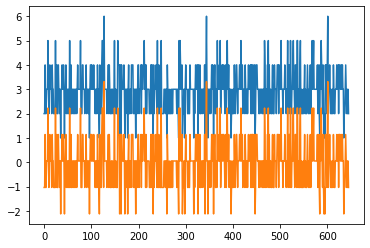

In [55]:
df_z["Rooms"].plot(), df_z["Rooms_new"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x18459239898>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18459239898>)

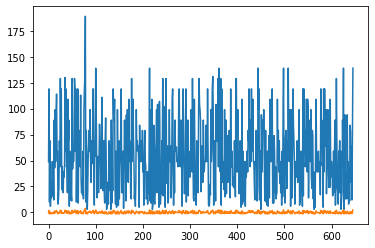

In [56]:
df_z["Age"].plot(), df_z["Age_new"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x184592b2f28>,
 <matplotlib.axes._subplots.AxesSubplot at 0x184592b2f28>)

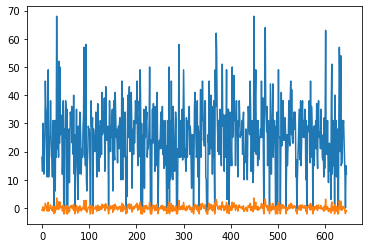

In [57]:
 df_z["travel_min_to_CBD"].plot(), df_z["travel_min_CBD_new"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x184592e73c8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x184592e73c8>)

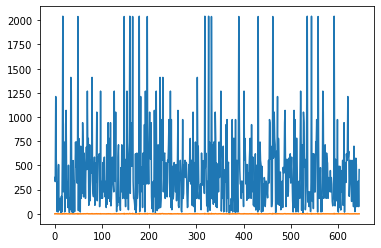

In [58]:
df_z["crime_C_average"].plot(), df_z["crime_C_average_new"].plot()

#### Building the linear regression model after zscore normalization

In [59]:
X_train, X_test, y_train, y_test = train_test_split(df_z[['Rooms_new','Age_new','travel_min_CBD_new','crime_C_average_new']], df_z['Price'], random_state=101)

In [60]:
lm_z = LinearRegression()
lm_z.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [61]:
r_sq = lm_z.score(X_test,y_test)
print("The r squared value is :", r_sq)

The r squared value is : 0.41915731496417485


 ### MinMax Noramlisation


Using the scikit for minmax normalization

In [62]:
minmax_scale = preprocessing.MinMaxScaler().fit(df[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age' ]])
df_minmax = minmax_scale.transform(df[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age' ]])
df_minmax[0:5]

D:\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int32, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


array([[0.2       , 0.18324351, 0.27536232, 0.24731183],
       [0.2       , 0.16266536, 0.20289855, 0.62365591],
       [0.6       , 0.5933366 , 0.44927536, 0.03763441],
       [0.2       , 0.28123469, 0.39130435, 0.35483871],
       [0.2       , 0.22341989, 0.1884058 , 0.01612903]])

In [63]:
df_mm = df[['Rooms', 'crime_C_average', 'travel_min_to_CBD', 'Age', 'Price']]

In [64]:
df_mm['Rooms_new'] = df_minmax[:,0]
df_mm['crime_C_average_new'] = df_minmax[:,1]
df_mm['travel_min_CBD_new'] = df_minmax[:,2]
df_mm[ 'Age_new'] =  df_minmax[:,3]

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexi

In [65]:
df_mm.head()

,Rooms,crime_C_average,travel_min_to_CBD,Age,Price,Rooms_new,crime_C_average_new,travel_min_CBD_new,Age_new
0,2,375,18,49,573000.0,0.2,0.183244,0.275362,0.247312
1,2,333,13,119,1180000.0,0.2,0.162665,0.202899,0.623656
2,4,1212,30,10,618350.0,0.6,0.593337,0.449275,0.037634
3,2,575,26,69,835000.0,0.2,0.281235,0.391304,0.354839
4,2,457,12,6,630000.0,0.2,0.223420,0.188406,0.016129


In [66]:
print("Age:\n",  "Mean before minmax normalization:", round(df_mm["Age"].mean(),2), "Mean After minmax normalization" , round(df_mm["Age_new"].mean(),5))
print("travel_min_CBD:\n", "Mean before minmax normalization:", round(df_mm["travel_min_to_CBD"].mean(),2), "Mean After minmax normalization", round(df_mm["travel_min_CBD_new"].mean(),2))
print("crime_C_average:\n", "Mean before minmax normalization:", round(df_mm["crime_C_average"].mean(), 2), "Mean After minmax normalization", round(df_mm["crime_C_average_new"].mean(), 2))
print("Rooms:\n", "Mean before minmax normaization:", round(df_mm["Rooms"].mean(),2), "Mean After minmax normalization", round(df_mm["Rooms_new"].mean(), 2))

Age:
 Mean before minmax normalization: 54.56 Mean After minmax normalization 0.27719
travel_min_CBD:
 Mean before minmax normalization: 24.97 Mean After minmax normalization 0.38
crime_C_average:
 Mean before minmax normalization: 448.82 Mean After minmax normalization 0.22
Rooms:
 Mean before minmax normaization: 2.95 Mean After minmax normalization 0.39


### Comparing the variables before and after minmax normalization by plotting the original and normalized values

(<matplotlib.axes._subplots.AxesSubplot at 0x18459396e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x18459396e80>)

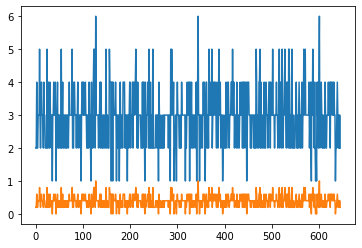

In [67]:
df_mm["Rooms"].plot(), df_mm["Rooms_new"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x184593800f0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x184593800f0>)

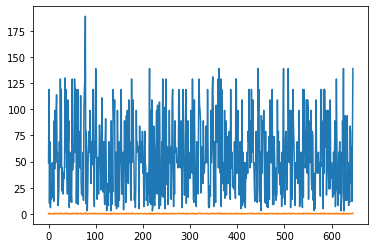

In [68]:
df_mm["Age"].plot(), df_mm["Age_new"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x1845c06c978>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1845c06c978>)

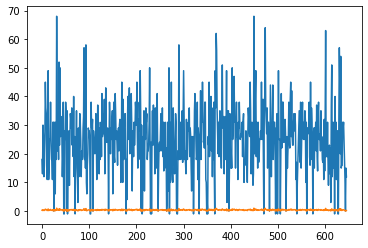

In [69]:
df_mm["travel_min_to_CBD"].plot(), df_mm["travel_min_CBD_new"].plot()

(<matplotlib.axes._subplots.AxesSubplot at 0x1845c492080>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1845c492080>)

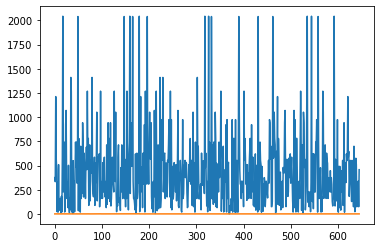

In [70]:
df_mm["crime_C_average"].plot(), df_mm["crime_C_average_new"].plot()

#### Building the linear regression model after minmax normalization

In [71]:
X_train, X_test, y_train, y_test = train_test_split(df_mm[['Rooms_new','Age_new','travel_min_CBD_new','crime_C_average_new']], df_mm['Price'], random_state=101)

In [72]:
lm_mm = LinearRegression()
lm_mm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
r_sq = lm_mm.score(X_test,y_test)
print("The r squared value is :", r_sq)

The r squared value is : 0.4191573149641742


From the above values, we can see that there is large gap between the mean values before standardization. After standardizaton, the mean values are closer to each other.

#### Ploting original, the standardised and normalised data values for Rooms and travel_min_CBD variables


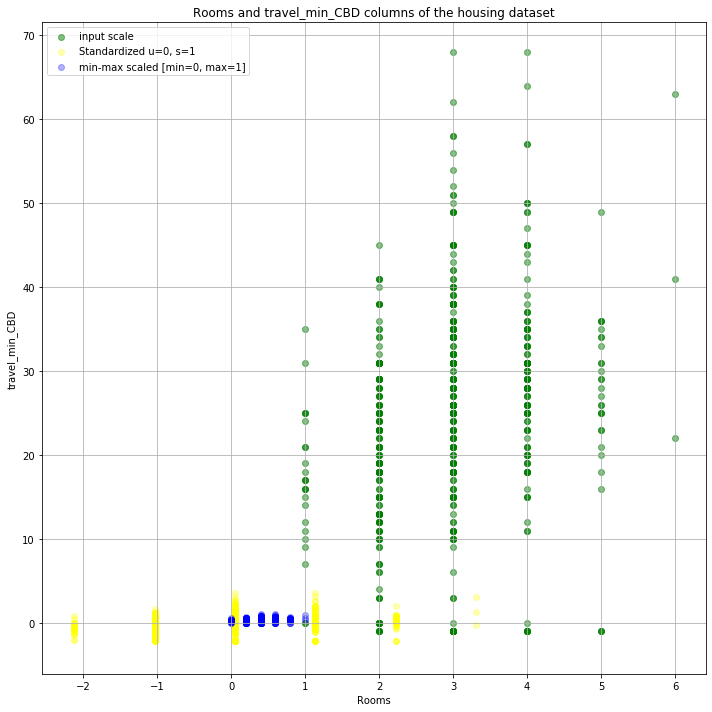

In [74]:
from matplotlib import pyplot as plt

def plot():
    f = plt.figure(figsize=(10,10))

    plt.scatter(df['Rooms'], df['travel_min_to_CBD'],
            color='green', label='input scale', alpha=0.5)

    plt.scatter(df_z['Rooms_new'], df_z['travel_min_CBD_new'], color = 'yellow',
             label='Standardized u=0, s=1', alpha=0.3) 
    
    plt.scatter(df_mm['Rooms_new'], df_mm['travel_min_CBD_new'],
            color='blue', label='min-max scaled [min=0, max=1]', alpha=0.3)

    plt.title('Rooms and travel_min_CBD columns of the housing dataset')
    plt.xlabel('Rooms')
    plt.ylabel('travel_min_CBD')
    plt.legend(loc='upper left')
    plt.grid()
    plt.tight_layout()

plot()
plt.show()

The above graph depicts the original, standardized and minmax normalized values. We can see that the purpose of normalization was to reduce the gap between the data points so as to make better predictions. In this case, the min max normalization would be prefered as compared to the Z-score normalization as the data points are closer after min-max normalization

### Data Transformation
There are mainly three types of transformations:

1) Root transformation

2) Square power transformation

3) Log transformation

#### Plots before applying transformation

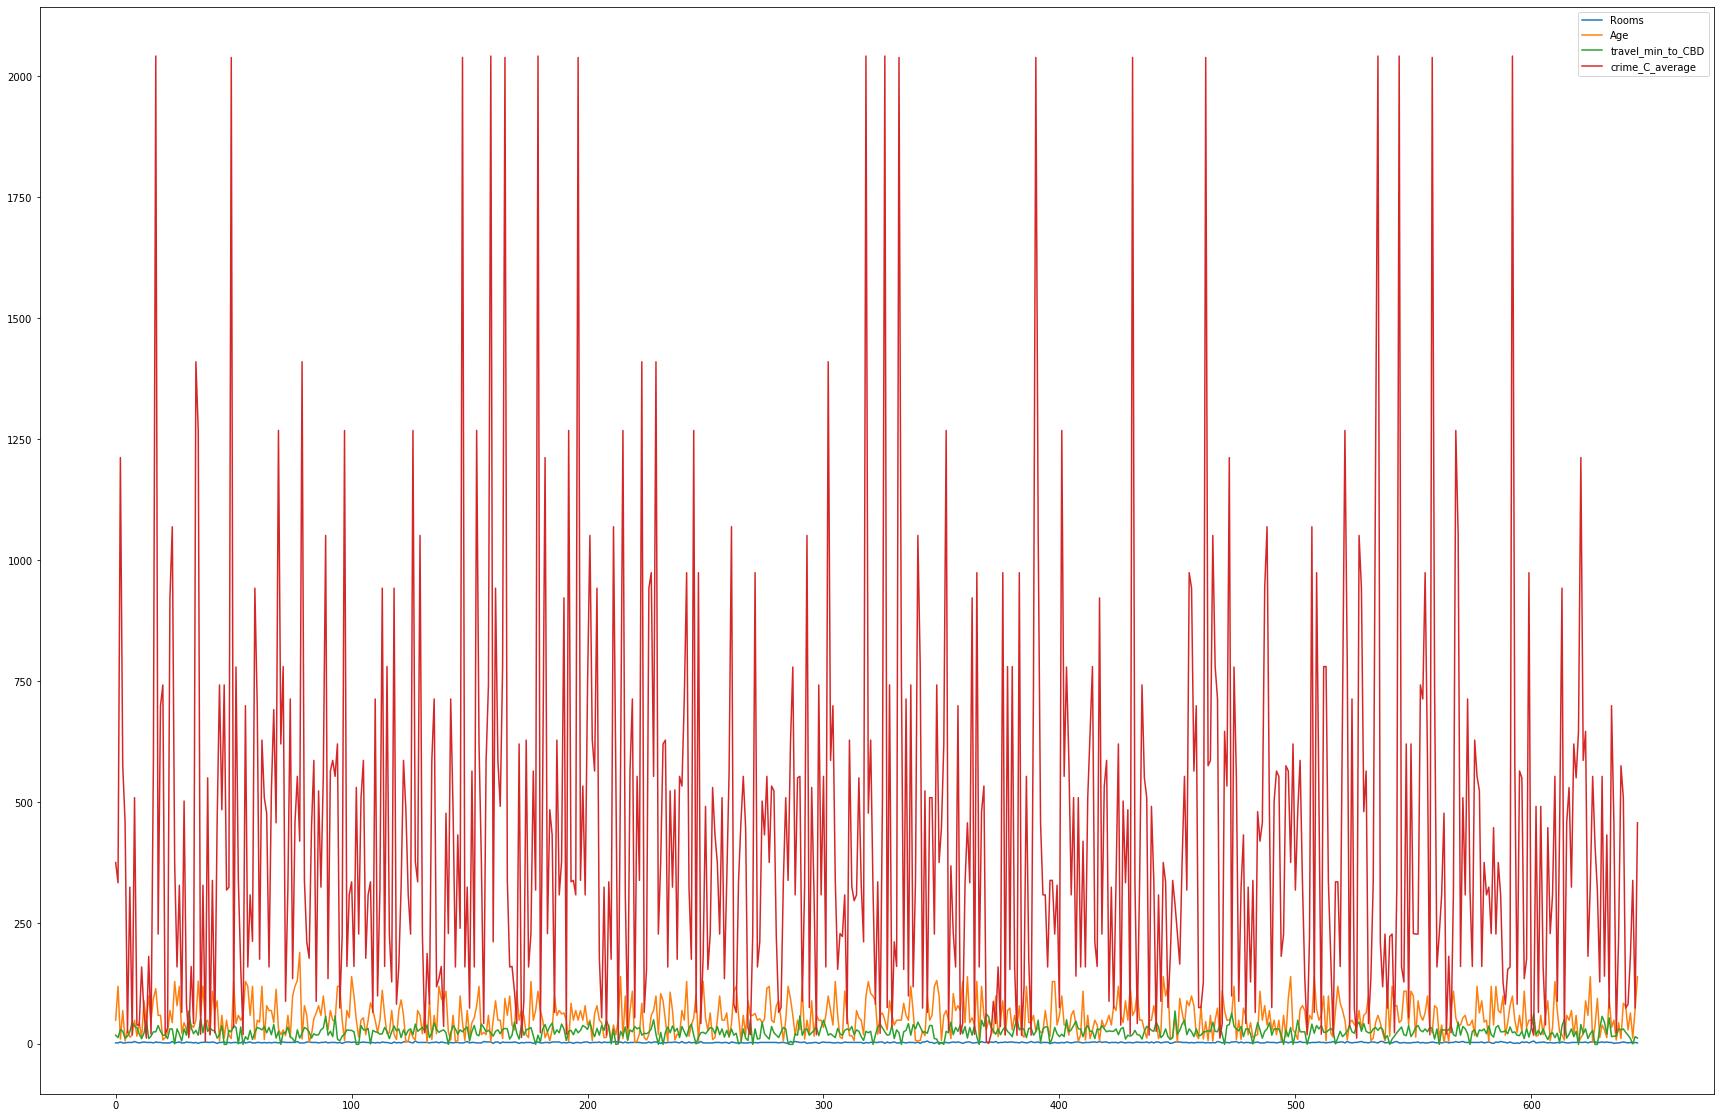

In [75]:
#plt.figure(figsize=(30,20))
df[["Rooms", "Age", "travel_min_to_CBD", "crime_C_average"]].plot(figsize=(30,20))
plt.show()

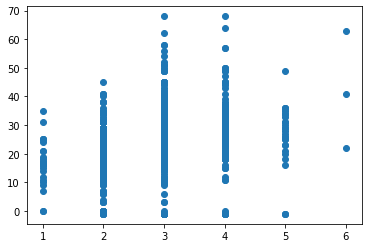

In [76]:
plt.scatter(df["Rooms"], df["travel_min_to_CBD"])# Before transformations

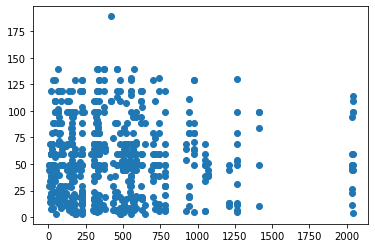

In [77]:
plt.scatter(df["crime_C_average"], df["Age"])

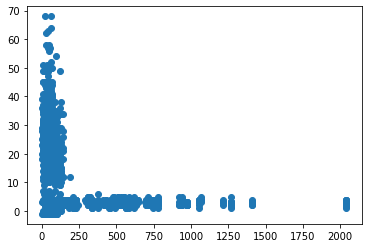

In [78]:
plt.scatter([df.crime_C_average, df.Age], [df.Rooms, df.travel_min_to_CBD])

In [79]:
df = df[["Rooms", "Age", "travel_min_to_CBD", "crime_C_average", "Price"]]

###  Root transformation:
In Root transformation, the square root of the desired variables is calculated and used to build the model

In [80]:
df['Age_rt'] = None
i = 0
for row in df.iterrows():
    df['Age_rt'].at[i] = math.sqrt(df["Age"][i])
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt
0,2,49,18,375,573000.0,7
1,2,119,13,333,1180000.0,10.9087
2,4,10,30,1212,618350.0,3.16228
3,2,69,26,575,835000.0,8.30662
4,2,6,12,457,630000.0,2.44949


In [81]:
df['Rooms_rt'] = None
i = 0
for row in df.iterrows():
    df['Rooms_rt'].at[i] = math.sqrt(df["Rooms"][i])
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt
0,2,49,18,375,573000.0,7,1.41421
1,2,119,13,333,1180000.0,10.9087,1.41421
2,4,10,30,1212,618350.0,3.16228,2
3,2,69,26,575,835000.0,8.30662,1.41421
4,2,6,12,457,630000.0,2.44949,1.41421


In [82]:
df['crime_C_average_rt'] = None
i = 0
for row in df.iterrows():
    df['crime_C_average_rt'].at[i] = math.sqrt(df["crime_C_average"][i])
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt
0,2,49,18,375,573000.0,7,1.41421,19.3649
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483
2,4,10,30,1212,618350.0,3.16228,2,34.8138
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776


In [83]:
df['travel_min_CBD_rt'] = None
i = 0
for row in df.iterrows():
    if df['travel_min_to_CBD'][i] < 0:
        df['travel_min_CBD_rt'].at[i] = 0
    #print(df['travel_min_CBD'][i])
    else:
        df['travel_min_CBD_rt'].at[i] = math.sqrt(df["travel_min_to_CBD"][i])
    
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641


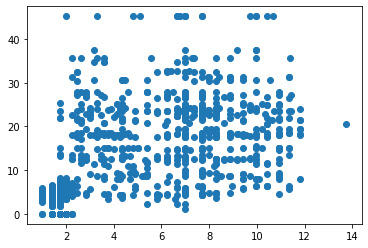

In [84]:
plt.scatter([df.Age_rt, df.Rooms_rt], [df.crime_C_average_rt, df.travel_min_CBD_rt]) 

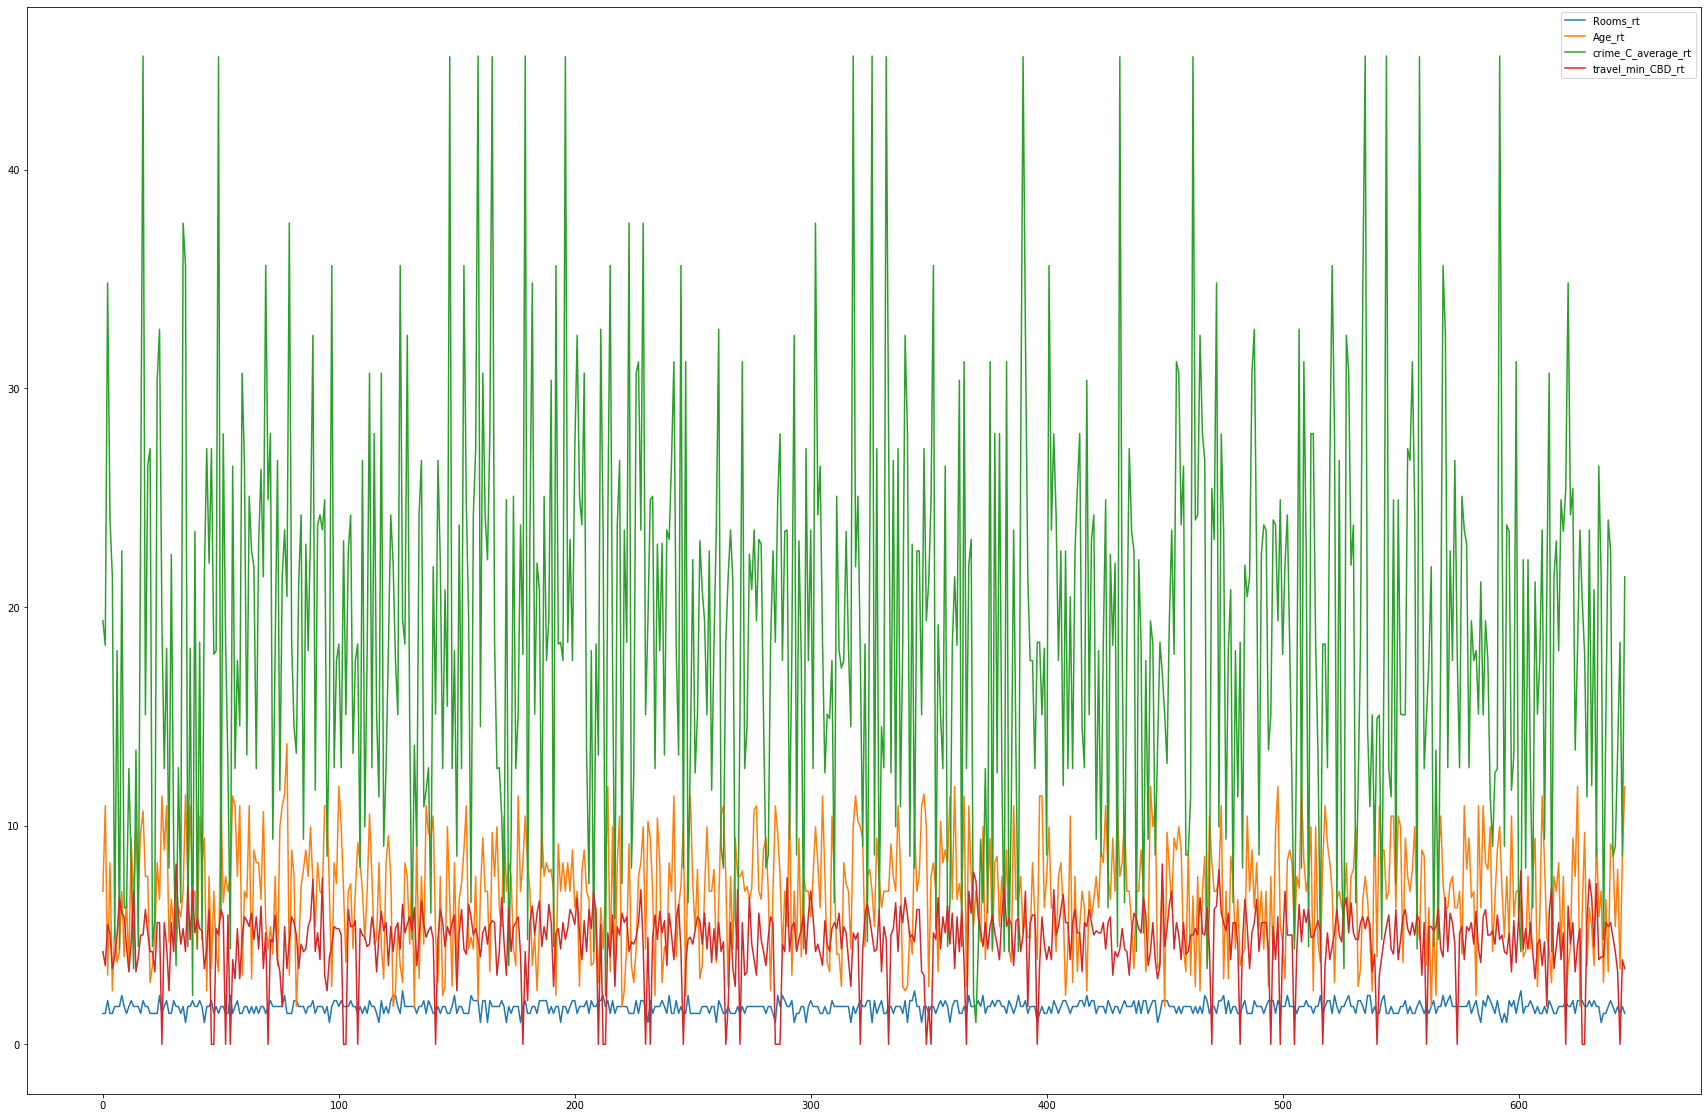

In [85]:
#plt.figure(figsize=(30,20))
df[["Rooms_rt", "Age_rt", "crime_C_average_rt", "travel_min_CBD_rt"]].plot(figsize=(30,20))
plt.show()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age_rt','Rooms_rt','crime_C_average_rt','travel_min_CBD_rt']], df['Price'], random_state=101)


In [87]:
lm_rt = LinearRegression()
lm_rt.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [88]:
r_sq = lm_rt.score(X_test,y_test)
print("The r squared value is :", r_sq)

The r squared value is : 0.4150567616021301


### Square Transformation


In [89]:
df['Age_sq'] = None
i = 0
for row in df.iterrows():
    df['Age_sq'].at[i] = math.pow(df["Age"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36


In [90]:
df['Rooms_sq'] = None
i = 0
for row in df.iterrows():
    df['Rooms_sq'].at[i] = math.pow(df["Rooms"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4


In [91]:
df['crime_C_average_sq'] = None
i = 0
for row in df.iterrows():
    df['crime_C_average_sq'].at[i] = math.pow(df["crime_C_average"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849


In [92]:
df['travel_min_CBD_sq'] = None
i = 0
for row in df.iterrows():
    df['travel_min_CBD_sq'].at[i] = math.pow(df["travel_min_to_CBD"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq,travel_min_CBD_sq
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625,324
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889,169
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06,900
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625,676
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849,144


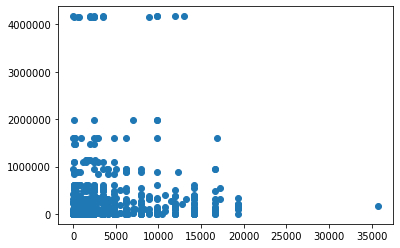

In [93]:
plt.scatter([df.Age_sq, df.Rooms_sq], [df.crime_C_average_sq, df.travel_min_CBD_sq]) 

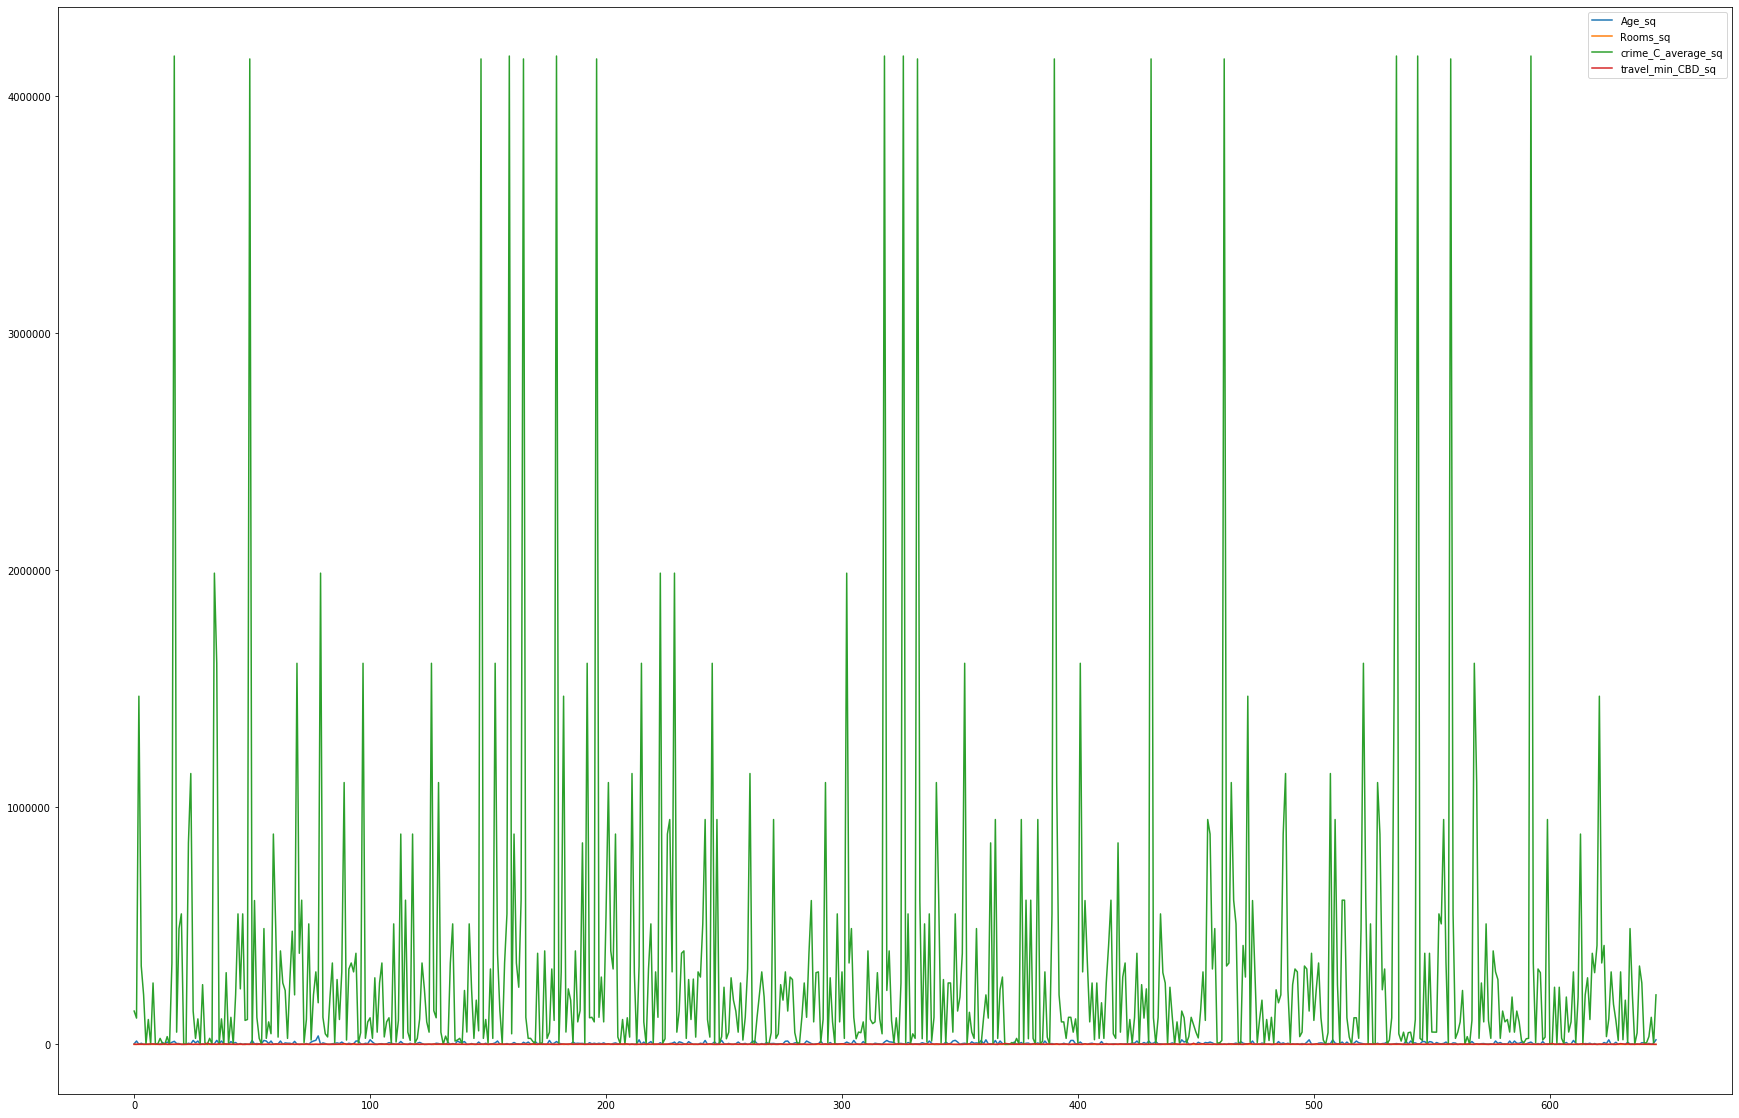

In [94]:
#plt.figure(figsize=(30,20))
df[["Age_sq", "Rooms_sq", "crime_C_average_sq", "travel_min_CBD_sq"]].plot(figsize=(30,20))
plt.show()

From the above graph, we can see that the square  transformation has expanded the data values.

In [95]:
X_train, X_test, y_train, y_test = train_test_split(df[['Age_sq','Rooms_sq','crime_C_average_sq','travel_min_CBD_sq']], df['Price'], random_state=101)

In [96]:
lm_sq = LinearRegression()
lm_sq.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [97]:
r_sq = lm_mm.score(X_test,y_test)
print("The r squared value is :", r_sq)

The r squared value is : -2722843915022.8257


### Log Transformation

In [98]:
df['Age_log'] = None
i = 0
for row in df.iterrows():
    df['Age_log'].at[i] = math.log(df["Age"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq,travel_min_CBD_sq,Age_log
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625,324,5.61471
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889,169,6.89482
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06,900,3.32193
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625,676,6.10852
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849,144,2.58496


In [99]:
df['Rooms_log'] = None
i = 0
for row in df.iterrows():
    df['Rooms_log'].at[i] = math.log(df["Rooms"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq,travel_min_CBD_sq,Age_log,Rooms_log
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625,324,5.61471,1
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889,169,6.89482,1
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06,900,3.32193,2
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625,676,6.10852,1
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849,144,2.58496,1


In [100]:
df['Rooms_log'] = None
i = 0
for row in df.iterrows():
    df['Rooms_log'].at[i] = math.log(df["Rooms"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq,travel_min_CBD_sq,Age_log,Rooms_log
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625,324,5.61471,1
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889,169,6.89482,1
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06,900,3.32193,2
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625,676,6.10852,1
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849,144,2.58496,1


In [101]:
import math
df['crime_C_average_log'] = None
i = 0
for row in df.iterrows():
    df['crime_C_average_log'].at[i] = math.log(df["crime_C_average"][i], 2)
    i += 1

df.head()

,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq,travel_min_CBD_sq,Age_log,Rooms_log,crime_C_average_log
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625,324,5.61471,1,8.55075
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889,169,6.89482,1,8.37938
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06,900,3.32193,2,10.2432
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625,676,6.10852,1,9.16742
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849,144,2.58496,1,8.83605


In [102]:
#df[("travel_min_CBD")] = df[("travel_min_CBD")].fillna(0)
df['travel_min_CBD_log'] = None
i=0
for row in df.iterrows():
    if df['travel_min_to_CBD'][i] < 1:
        df['travel_min_CBD_log'][i] = 0
    #print(df['travel_min_CBD'][i])
    else:
        df['travel_min_CBD_log'].at[i] = math.log(df["travel_min_to_CBD"][i], 2)
    i += 1
df.head()

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Rooms,Age,travel_min_to_CBD,crime_C_average,Price,Age_rt,Rooms_rt,crime_C_average_rt,travel_min_CBD_rt,Age_sq,Rooms_sq,crime_C_average_sq,travel_min_CBD_sq,Age_log,Rooms_log,crime_C_average_log,travel_min_CBD_log
0,2,49,18,375,573000.0,7,1.41421,19.3649,4.24264,2401,4,140625,324,5.61471,1,8.55075,4.16993
1,2,119,13,333,1180000.0,10.9087,1.41421,18.2483,3.60555,14161,4,110889,169,6.89482,1,8.37938,3.70044
2,4,10,30,1212,618350.0,3.16228,2,34.8138,5.47723,100,16,1.46894e+06,900,3.32193,2,10.2432,4.90689
3,2,69,26,575,835000.0,8.30662,1.41421,23.9792,5.09902,4761,4,330625,676,6.10852,1,9.16742,4.70044
4,2,6,12,457,630000.0,2.44949,1.41421,21.3776,3.4641,36,4,208849,144,2.58496,1,8.83605,3.58496


In [103]:
X_train, X_test, y_train, y_test = train_test_split(df[['Rooms_log','Age_log','travel_min_CBD_log','crime_C_average_log']], df_mm['Price'], random_state=101)


In [104]:
lm_log = LinearRegression()
lm_log.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [105]:
r_sq = lm_log.score(X_test,y_test)
print("The r squared value is :", r_sq)

The r squared value is : 0.38670288183472146


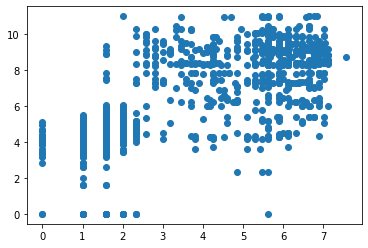

In [106]:
plt.scatter([df.Age_log, df.Rooms_log], [df.crime_C_average_log, df.travel_min_CBD_log]) 

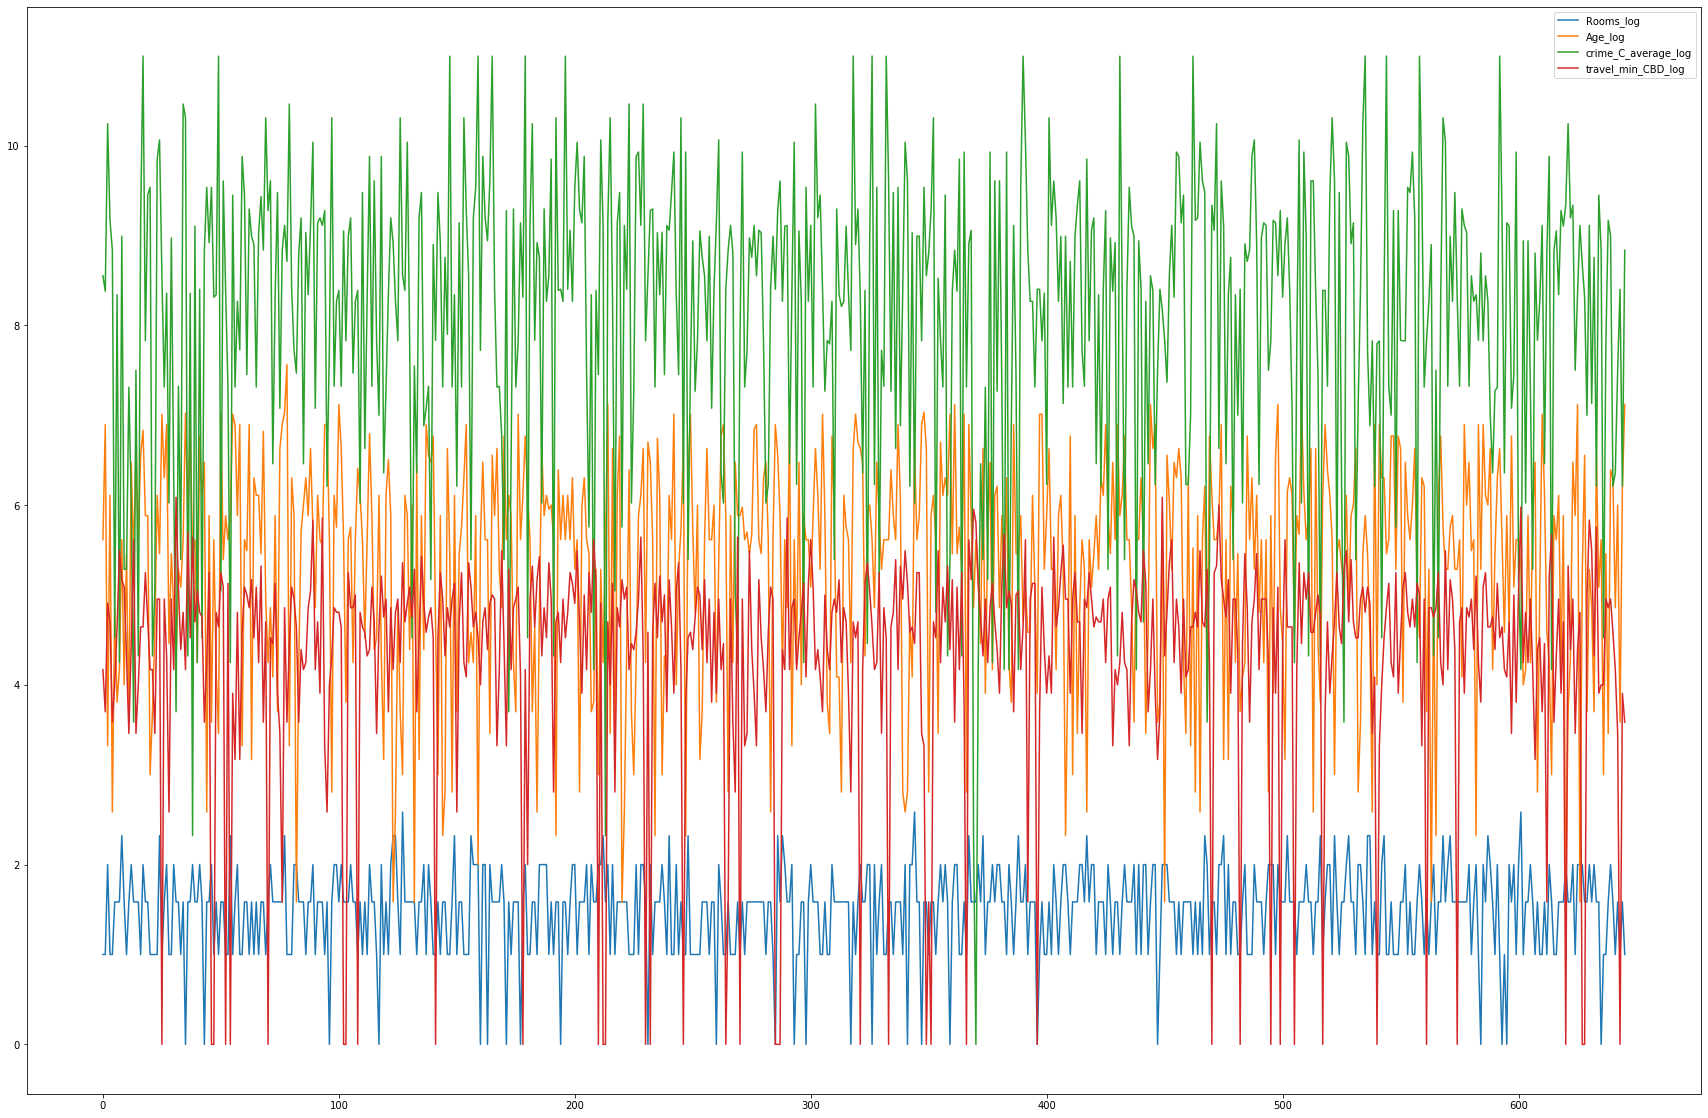

In [107]:
#plt.figure(figsize=(30,20))
df[["Rooms_log", "Age_log", "crime_C_average_log", "travel_min_CBD_log"]].plot(figsize=(30,20))
plt.show()

From the above graph, we can see that the square root transformation has compressed the data values better than the root transformation. Hence, it would be prefered over the other transformations.